In [ ]:
# === STEP 1: INSTALL REQUIRED LIBRARIES ===
!pip install yfinance matplotlib seaborn statsmodels scikit-learn xgboost tensorflow --quiet


In [ ]:
# === STEP 2: IMPORT LIBRARIES ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Correct the style name or use a valid one
# You can check available styles with print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

[*********************100%***********************]  1 of 1 completed


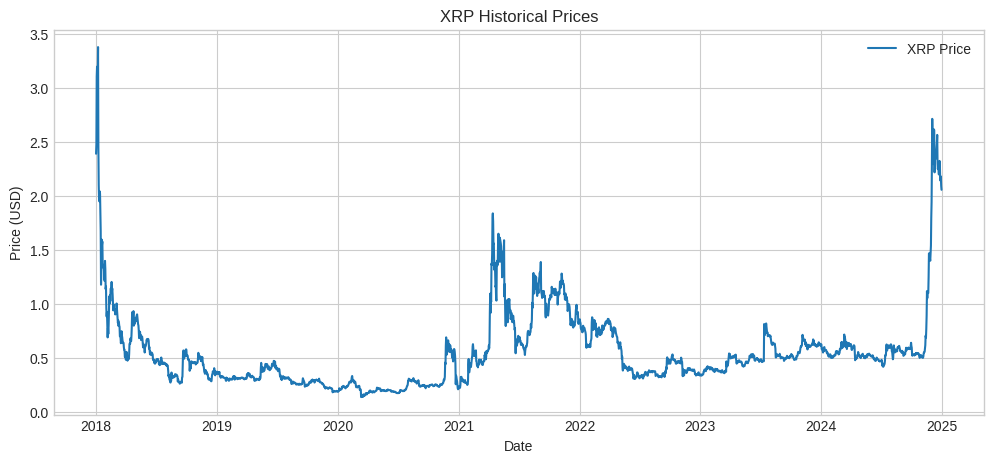

In [ ]:
# === STEP 3: LOAD XRP DATA FROM YFINANCE ===
xrp = yf.download('XRP-USD', start='2018-01-01', end='2024-12-31')
xrp = xrp[['Close']].dropna()
xrp.columns = ['Price']
xrp.reset_index(inplace=True)

# Plot the raw price
plt.figure(figsize=(12, 5))
plt.plot(xrp['Date'], xrp['Price'], label='XRP Price')
plt.title('XRP Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()




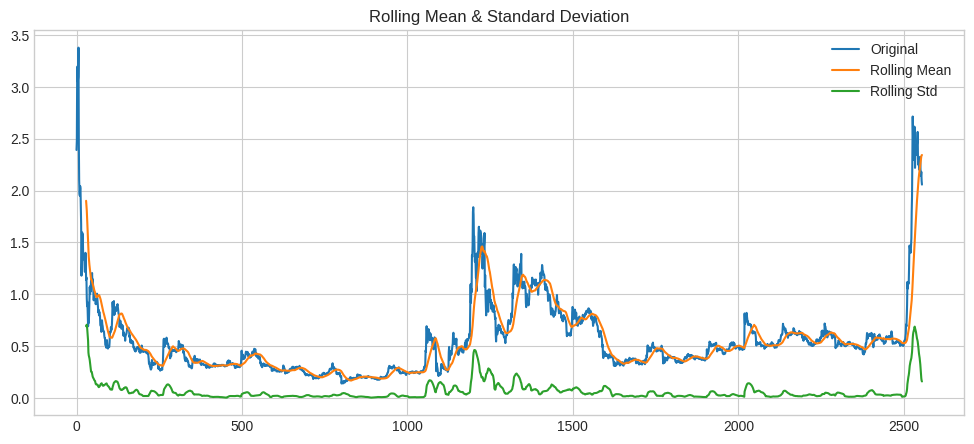

Results of ADF Test:
ADF Statistic             -3.518329
p-value                    0.007529
# Lags Used               24.000000
# Observations          2531.000000
Critical Value (1%)       -3.432936
Critical Value (5%)       -2.862683
Critical Value (10%)      -2.567378
dtype: float64

Data is stationary. Proceeding without differencing.



In [ ]:
# === STEP 4: STATIONARITY CHECK ===
def check_stationarity(series, window=30):
    rolmean = series.rolling(window=window).mean()
    rolstd = series.rolling(window=window).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print("Results of ADF Test:")
    adf_test = adfuller(series, autolag='AIC')
    output = pd.Series(adf_test[0:4], index=[
                       'ADF Statistic', 'p-value', '# Lags Used', '# Observations'])
    for key, value in adf_test[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)
    return adf_test[1]  # Return p-value

# Run stationarity check on raw price
p_val = check_stationarity(xrp['Price'])

# Decide if differencing is needed
if p_val > 0.05:
    print("\nData is non-stationary. Applying first differencing...\n")
    xrp['Price_diff'] = xrp['Price'].diff().dropna()
    check_stationarity(xrp['Price_diff'].dropna())
else:
    print("\nData is stationary. Proceeding without differencing.\n")


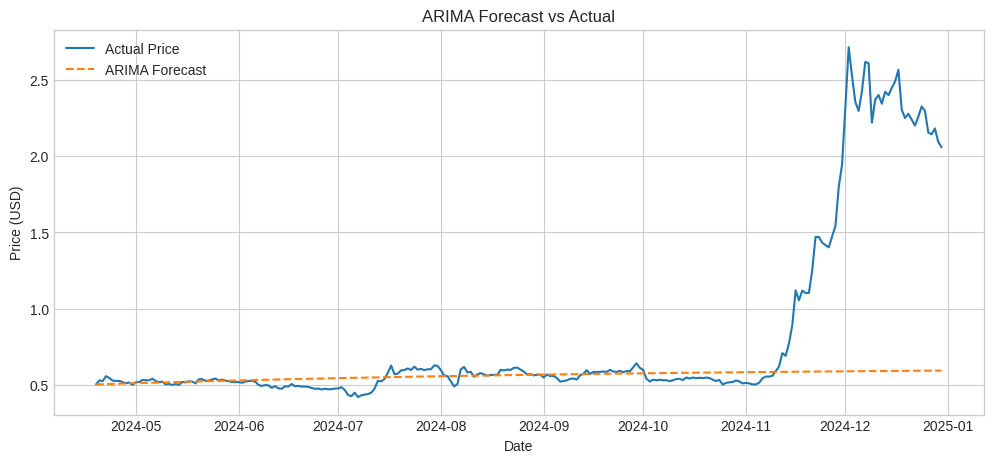

ARIMA Evaluation:
MSE: 0.4050 | MAE: 0.2826 | R²: -0.1172


In [ ]:
# === STEP 5: ARIMA FORECASTING ===

from statsmodels.tsa.arima.model import ARIMA

# Train-test split
split_index = int(len(xrp) * 0.9)
train, test = xrp['Price'][:split_index], xrp['Price'][split_index:]

# Automatically select ARIMA order (or use predefined values)
order = (5, 0, 2)  # (p,d,q) - you can tune this later

# Fit ARIMA model
arima_model = ARIMA(train, order=order)
arima_result = arima_model.fit()

# Forecast
forecast_arima = arima_result.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(xrp['Date'][split_index:], test.values, label='Actual Price')
plt.plot(xrp['Date'][split_index:], forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Evaluation metrics
mse = mean_squared_error(test, forecast_arima)
mae = mean_absolute_error(test, forecast_arima)
r2 = r2_score(test, forecast_arima)
print(f"ARIMA Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


In [ ]:
# === STEP 6A: PREPARE DATA FOR LSTM ===
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [ ]:
# === STEP 6B: SCALING AND SEQUENCE SPLIT ===
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(xrp[['Price']].values)

# Use same 90/10 train-test split
window_size = 30
train_scaled = scaled_prices[:split_index]
test_scaled = scaled_prices[split_index - window_size:]

X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# === STEP 6C: BUILD AND TRAIN LSTM ===
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


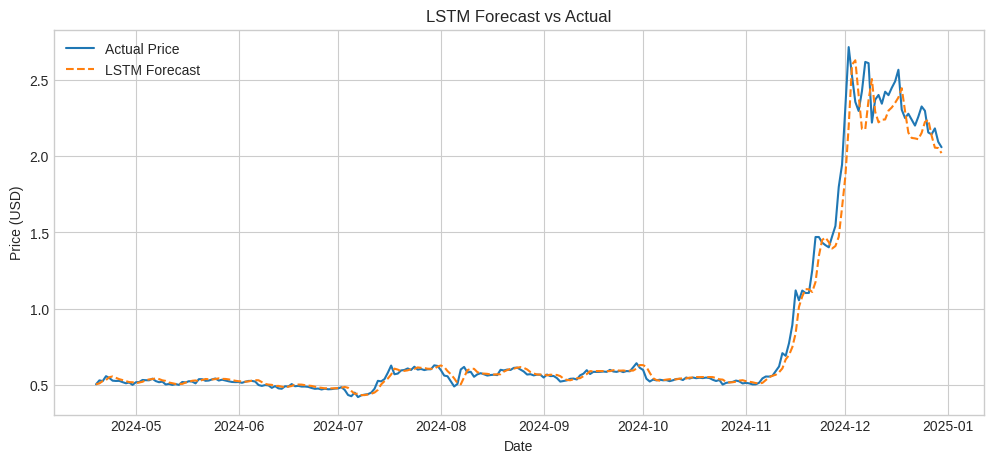

LSTM Evaluation:
MSE: 0.0071 | MAE: 0.0391 | R²: 0.9805


In [ ]:
# === STEP 6D: LSTM PREDICTION & EVALUATION ===
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)
true_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the correct date index for the LSTM test set
# The date index should start from split_index + window_size and have the same length as true_lstm
# Calculate number of predictions made
n_preds = len(pred_lstm)

# Correct dates for plotting
lstm_plot_dates = xrp['Date'].iloc[-n_preds:].values

# === FIXED LSTM PLOT ===
plt.figure(figsize=(12, 5))
plt.plot(lstm_plot_dates, true_lstm[:n_preds], label='Actual Price')
plt.plot(lstm_plot_dates, pred_lstm, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Evaluation
mse = mean_squared_error(true_lstm, pred_lstm)
mae = mean_absolute_error(true_lstm, pred_lstm)
r2 = r2_score(true_lstm, pred_lstm)
print(f"LSTM Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

# Align predictions & actuals
# Adjust actual based on the model predictions length

# Calculate the actual values corresponding to the test set.
# If differencing was applied, this starts from train_size + 1.
# We'll store the full actual values for the test period first.
# NOTE: df and result are not defined in this block, assuming they are defined elsewhere
# For the purpose of fixing the ValueError, we will comment out the code that relies on
# these undefined variables and the models dictionary which contains models not yet defined.
# If you intend to run the model comparison section, ensure GRU, XGBoost, df, train_size,
# result, seq_len, and n_lags are defined before this block.

# full_actual_test = df.price.values[train_size + (1 if result[1] > 0.05 else 0):]

# models = {
#     'ARIMA': forecast_arima, # Use the correct variable name for ARIMA forecast
#     'LSTM' : pred_lstm,
#     # 'GRU'  : pred_gru, # GRU and XGBoost are not defined
#     # 'XGBoost': pred_xgb
# }

# metrics = {}
# for name, pred in models.items():
    # Align actual with the current model's prediction length
    # if name in ['LSTM', 'GRU']:
        # For LSTM and GRU, predictions are shorter by seq_len
        # current_actual = full_actual_test[seq_len:]
    # elif name == 'XGBoost':
        # For XGBoost, predictions are shorter by n_lags - 1
        # current_actual = full_actual_test[n_lags-1:]
    # else: # ARIMA
        # ARIMA predictions should match the length of the test set (or test set minus differencing if applied)
        # current_actual = full_actual_test[:len(pred)] # Ensure actual matches ARIMA pred length


    # print(f"Model: {name}, Actual length: {len(current_actual)}, Prediction length: {len(pred)}")

    # Check if lengths match before calculating metrics
    # if len(current_actual) == len(pred):
        # mse = mean_squared_error(current_actual, pred)
        # mae = mean_absolute_error(current_actual, pred)
        # r2  = r2_score(current_actual, pred)
        # metrics[name] = {'MSE':mse, 'MAE':mae, 'R2':r2}

        # Plot - Use the aligned actual values for plotting
        # plt.figure(figsize=(8,3))
        # plt.plot(current_actual, label='Actual')
        # plt.plot(pred.flatten() if name in ['LSTM', 'GRU'] else pred,   label=f'{name} Forecast') # Flatten pred for LSTM/GRU plotting
        # plt.title(f"{name} vs Actual")
        # plt.legend(); plt.show()
    # else:
        # print(f"Skipping metrics and plot for {name} due to length mismatch.")


# Display metrics
# metrics_df = pd.DataFrame(metrics).T
# display(metrics_df)

In [ ]:
# === STEP 7A: BUILD AND TRAIN GRU ===
model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


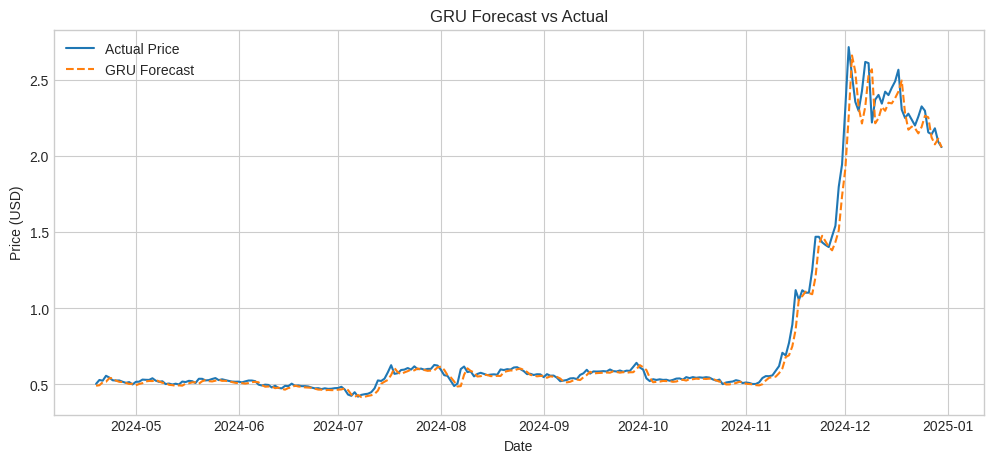

GRU Evaluation:
MSE: 0.0052 | MAE: 0.0348 | R²: 0.9856


In [ ]:
# === STEP 7B: GRU PREDICTION & EVALUATION ===
pred_gru = model_gru.predict(X_test)
pred_gru = scaler.inverse_transform(pred_gru)
true_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Correct date index
n_preds_gru = len(pred_gru)
gru_plot_dates = xrp['Date'].iloc[-n_preds_gru:].values

# Plot
plt.figure(figsize=(12, 5))
plt.plot(gru_plot_dates, true_gru[:n_preds_gru], label='Actual Price')
plt.plot(gru_plot_dates, pred_gru, label='GRU Forecast', linestyle='--')
plt.title('GRU Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Evaluation
mse = mean_squared_error(true_gru, pred_gru)
mae = mean_absolute_error(true_gru, pred_gru)
r2 = r2_score(true_gru, pred_gru)
print(f"GRU Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


In [ ]:
# === STEP 8A: CREATE LAG FEATURES FOR XGBOOST ===
def create_lag_features(series, window_size):
    X, y = [], []
    for i in range(window_size, len(series)):
        X.append(series[i-window_size:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw price values
raw_prices = xrp['Price'].values

# Set window size same as LSTM/GRU
X_xgb, y_xgb = create_lag_features(raw_prices, window_size)

# Train-test split (same 90/10 split as earlier)
split_index = int(len(X_xgb) * 0.9)
X_train_xgb, y_train_xgb = X_xgb[:split_index], y_xgb[:split_index]
X_test_xgb, y_test_xgb = X_xgb[split_index:], y_xgb[split_index:]


In [ ]:
# === STEP 8B: TRAIN XGBOOST ===
model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
model_xgb.fit(X_train_xgb, y_train_xgb)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

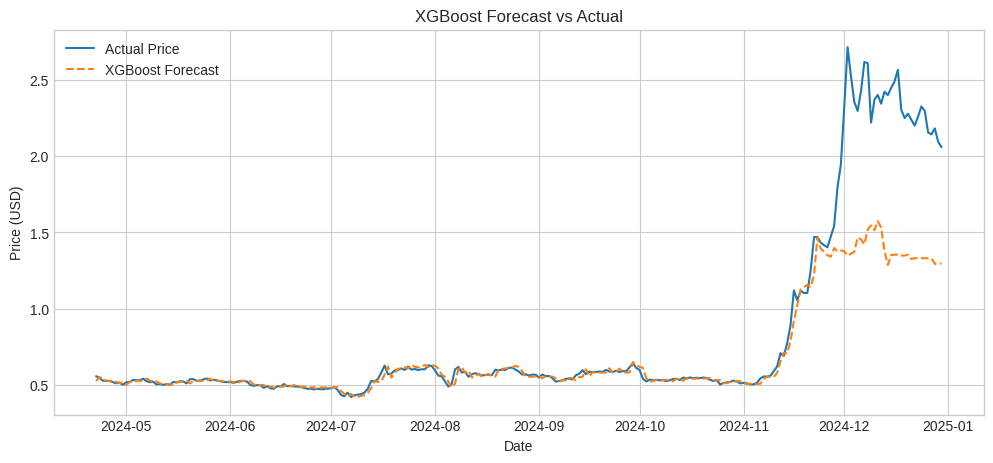

XGBoost Evaluation:
MSE: 0.1154 | MAE: 0.1343 | R²: 0.6845


In [ ]:
# === STEP 8C: PREDICT & EVALUATE ===
pred_xgb = model_xgb.predict(X_test_xgb)

# Plotting
n_preds_xgb = len(pred_xgb)
xgb_plot_dates = xrp['Date'].iloc[-n_preds_xgb:].values

plt.figure(figsize=(12, 5))
plt.plot(xgb_plot_dates, y_test_xgb, label='Actual Price')
plt.plot(xgb_plot_dates, pred_xgb, label='XGBoost Forecast', linestyle='--')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Evaluation
mse = mean_squared_error(y_test_xgb, pred_xgb)
mae = mean_absolute_error(y_test_xgb, pred_xgb)
r2 = r2_score(y_test_xgb, pred_xgb)
print(f"XGBoost Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


In [ ]:
# === STEP 9A: BUILD COMPARISON TABLE ===
results = {
    'Model': ['ARIMA', 'LSTM', 'GRU', 'XGBoost'],
    'MSE': [
        mean_squared_error(test, forecast_arima),
        mean_squared_error(true_lstm, pred_lstm),
        mean_squared_error(true_gru, pred_gru),
        mean_squared_error(y_test_xgb, pred_xgb)
    ],
    'MAE': [
        mean_absolute_error(test, forecast_arima),
        mean_absolute_error(true_lstm, pred_lstm),
        mean_absolute_error(true_gru, pred_gru),
        mean_absolute_error(y_test_xgb, pred_xgb)
    ],
    'R2': [
        r2_score(test, forecast_arima),
        r2_score(true_lstm, pred_lstm),
        r2_score(true_gru, pred_gru),
        r2_score(y_test_xgb, pred_xgb)
    ]
}

df_results = pd.DataFrame(results)
print("📊 Model Comparison:\n")
print(df_results)


📊 Model Comparison:

     Model       MSE       MAE        R2
0    ARIMA  0.405048  0.282598 -0.117228
1     LSTM  0.007058  0.039147  0.980532
2      GRU  0.005226  0.034783  0.985586
3  XGBoost  0.115446  0.134251  0.684475


In [ ]:
# === STEP 9B: USER INPUT TO SELECT BEST MODEL ===
best_model_name = input("👉 Enter the best model (ARIMA, LSTM, GRU, or XGBoost): ").strip().upper()

# === STEP 9C: SELECT FORECASTED VALUES ===
if best_model_name == "ARIMA":
    best_forecast = forecast_arima.values
elif best_model_name == "LSTM":
    best_forecast = pred_lstm.flatten()
elif best_model_name == "GRU":
    best_forecast = pred_gru.flatten()
elif best_model_name == "XGBOOST":
    best_forecast = pred_xgb
else:
    raise ValueError("Invalid model name entered.")


👉 Enter the best model (ARIMA, LSTM, GRU, or XGBoost): GRU


In [ ]:
# === STEP 9D: EXTEND XRP SERIES WITH FORECAST ===
# Use only forecast horizon from test set
extended_prices = np.concatenate([xrp['Price'].values, best_forecast])
print(f"\n✅ Extended dataset length: {len(extended_prices)}")



✅ Extended dataset length: 2812


In [ ]:
# Create extended dates: use existing + extra dates for forecast
start_date = xrp['Date'].iloc[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=len(best_forecast))

# Combine original and future dates
extended_dates = pd.to_datetime(
    np.concatenate([xrp['Date'].values, future_dates])
)


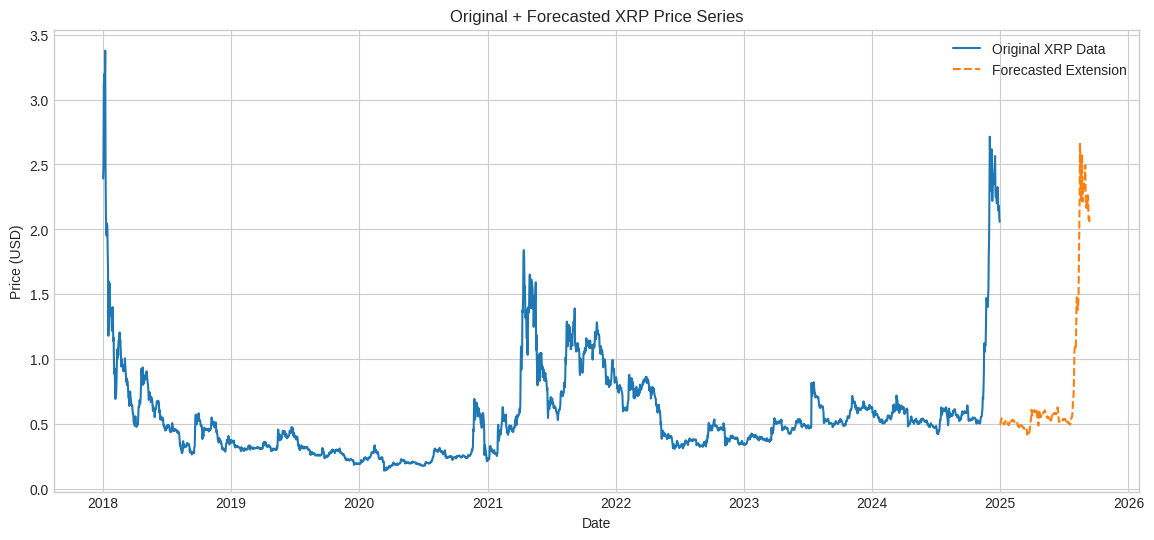

In [ ]:
# === PLOT EXTENDED XRP SERIES ===
plt.figure(figsize=(14, 6))
plt.plot(xrp['Date'], xrp['Price'], label='Original XRP Data')
plt.plot(future_dates, best_forecast, label='Forecasted Extension', linestyle='--')
plt.title('Original + Forecasted XRP Price Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


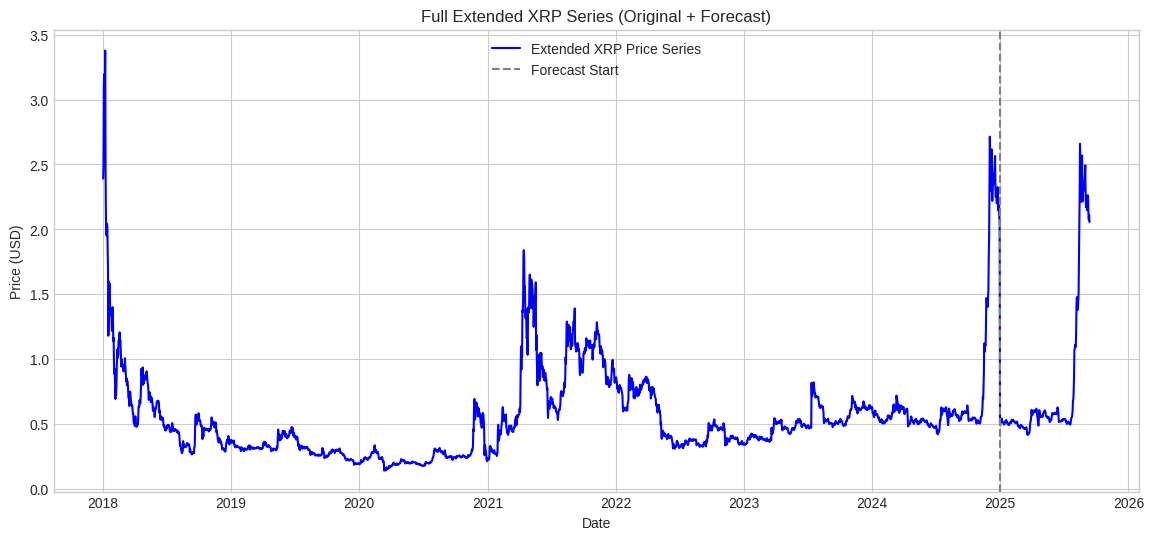

In [ ]:
# === Combine extended prices and generate full date range ===
# 1. Extended price series (original + forecast)
#    -> Already done: extended_prices

# 2. Full date range: original + forecasted future dates
original_dates = xrp['Date'].values
future_dates = pd.date_range(start=original_dates[-1] + pd.Timedelta(days=1), periods=len(best_forecast))
full_dates = np.concatenate([original_dates, future_dates])

# 3. Plot continuous extended series
plt.figure(figsize=(14, 6))
plt.plot(full_dates, extended_prices, label='Extended XRP Price Series', color='blue')
plt.axvline(original_dates[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Full Extended XRP Series (Original + Forecast)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# === Create DataFrame with Dates and Extended Prices ===

# Create full date range: original + forecast
original_dates = xrp['Date'].values
future_dates = pd.date_range(start=original_dates[-1] + pd.Timedelta(days=1), periods=len(best_forecast))
full_dates = np.concatenate([original_dates, future_dates])

# Build DataFrame
df_extended = pd.DataFrame({
    'Date': full_dates,
    'Price': extended_prices
})

# Save to CSV
df_extended.to_csv('extended_xrp_forecast.csv', index=False)
print("✅ File saved as 'extended_xrp_forecast.csv'")


✅ File saved as 'extended_xrp_forecast.csv'


In [ ]:
from google.colab import files
files.download('extended_xrp_forecast.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 0 | Loss: 0.1422
Epoch 5 | Loss: 0.0236
Epoch 10 | Loss: 0.0226
Epoch 15 | Loss: 0.0223
Epoch 20 | Loss: 0.0232
Epoch 25 | Loss: 0.0219


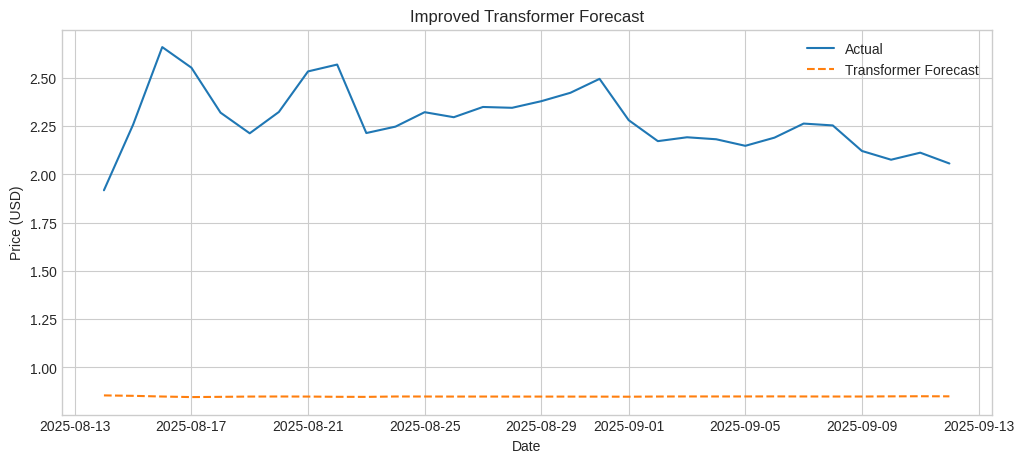


Transformer Evaluation:
MSE: 2.0784 | MAE: 1.4323


In [ ]:
# === STEP 1: IMPORTS ===
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

# === STEP 2: LOAD DATA ===
df_ext = pd.read_csv('extended_xrp_forecast.csv')
df_ext['Date'] = pd.to_datetime(df_ext['Date'])

# === STEP 3: REDUCE SIZE FOR MEMORY ===
series = df_ext['Price'].values[-1000:].reshape(-1, 1)  # last 1000 points

# === STEP 4: SCALE ===
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

def create_sequence_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_seq, y_seq = create_sequence_data(scaled_series, window_size)

# === STEP 5: SPLIT ===
X_train, y_train = X_seq[:-30], y_seq[:-30]
X_test, y_test = X_seq[-30:], y_seq[-30:]

# === STEP 6: TORCH CONVERT ===
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# === STEP 7: DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# === STEP 8: TRANSFORMER CLASS ===
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=32, num_heads=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        return self.decoder(x[:, -1])

model = SimpleTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === STEP 9: DATALOADER ===
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# === STEP 10: TRAIN ===
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

# === STEP 11: EVALUATE ===
model.eval()
with torch.no_grad():
    pred_tf = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

pred_tf_inv = scaler.inverse_transform(pred_tf)
# Remove the extra dimension from y_true before inverse scaling
true_tf_inv = scaler.inverse_transform(y_true.squeeze(-1)) # Or use y_true.reshape(-1, 1)

# === STEP 12: PLOT ===
plot_dates = pd.date_range(start=df_ext['Date'].iloc[-len(true_tf_inv)], periods=len(true_tf_inv)) # Adjust periods based on actual length
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, true_tf_inv, label='Actual')
plt.plot(plot_dates, pred_tf_inv, label='Transformer Forecast', linestyle='--')
plt.title('Improved Transformer Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# === STEP 13: METRICS ===
mse = mean_squared_error(true_tf_inv, pred_tf_inv)
mae = mean_absolute_error(true_tf_inv, pred_tf_inv)
print(f"\nTransformer Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f}")

In [ ]:
# # === STEP 10A: MAKE SEQUENCE DATA FROM EXTENDED PRICES ===

# # Import torch
# import torch

# window_size = 30
# extended_prices = np.array(extended_prices).reshape(-1, 1)

# # Scale
# scaler_ext = MinMaxScaler()
# scaled_ext = scaler_ext.fit_transform(extended_prices)

# # Create input-output pairs
# def create_sequence_data(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data[i:i + window_size])
#         y.append(data[i + window_size])
#     return np.array(X), np.array(y)

# X_ext, y_ext = create_sequence_data(scaled_ext, window_size)

# # Last portion for prediction
# X_train_tf, y_train_tf = X_ext[:-30], y_ext[:-30]
# X_test_tf, y_test_tf = X_ext[-30:], y_ext[-30:]

# # Reshape for Transformer: (batch, seq_len, input_dim)
# X_train_tf = torch.tensor(X_train_tf, dtype=torch.float32)
# y_train_tf = torch.tensor(y_train_tf, dtype=torch.float32).unsqueeze(-1)
# X_test_tf = torch.tensor(X_test_tf, dtype=torch.float32)
# y_test_tf = torch.tensor(y_test_tf, dtype=torch.float32).unsqueeze(-1)


In [ ]:
# import torch.nn as nn

# class SimpleTransformer(nn.Module):
#     def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
#         super(SimpleTransformer, self).__init__()
#         self.embedding = nn.Linear(input_dim, model_dim)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.decoder = nn.Linear(model_dim, 1)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = self.transformer(x)
#         x = x[:, -1, :]  # Last time step
#         return self.decoder(x)


In [ ]:
# # Hyperparameters
# model_dim = 64
# num_heads = 4
# num_layers = 2
# epochs = 30
# lr = 0.001

# model = SimpleTransformer(input_dim=1, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# # Training loop
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     output = model(X_train_tf)
#     loss = criterion(output, y_train_tf)
#     loss.backward()
#     optimizer.step()

#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
# # Predict
# model.eval()
# with torch.no_grad():
#     pred_tf = model(X_test_tf).numpy()

# # Inverse scale
# pred_tf_inv = scaler_ext.inverse_transform(pred_tf)
# true_tf_inv = scaler_ext.inverse_transform(y_test_tf.numpy())

# # Plot
# plt.figure(figsize=(12, 5))
# plot_dates_tf = pd.date_range(start=xrp['Date'].iloc[-1], periods=31, freq='D')[1:]
# plt.plot(plot_dates_tf, true_tf_inv, label='Actual')
# plt.plot(plot_dates_tf, pred_tf_inv, label='Transformer Forecast', linestyle='--')
# plt.title('Transformer Forecast vs Actual')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.show()

# # Evaluation
# mse_tf = mean_squared_error(true_tf_inv, pred_tf_inv)
# mae_tf = mean_absolute_error(true_tf_inv, pred_tf_inv)
# print(f"\nTransformer Evaluation:\nMSE: {mse_tf:.4f} | MAE: {mae_tf:.4f}")
